# Previsão do Volume de Comércio com Modelo SARIMA

Este projeto foca na aplicação de métodos estatísticos avançados para prever o volume do comércio no Brasil. Utilizamos uma abordagem de séries temporais, especificamente o modelo SARIMA (Seasonal AutoRegressive Integrated Moving Average), para modelar e prever os dados de comércio. O modelo SARIMA é bem adequado para dados de séries temporais que exibem sazonalidade, tendência e outros padrões não-estacionários.

## Estrutura do Projeto

O notebook segue uma sequência lógica e metodológica dividida nas seguintes etapas:

1. **Importação de Dados**: Carregamos os dados de comércio de um arquivo `.xlsx` para um DataFrame do pandas, garantindo que os dados estejam prontos para análise.
2. **Análise Exploratória de Dados (EDA)**: Realizamos uma EDA preliminar para entender as características fundamentais dos dados, incluindo visualizações da série temporal e estatísticas descritivas.
3. **Pré-processamento de Dados**: Preparamos os dados para modelagem, tratando valores ausentes e garantindo que as séries temporais estejam em formato adequado.
4. **Construção do Modelo SARIMA**: Selecionamos os parâmetros apropriados para o modelo SARIMA com base em critérios estatísticos e diagnósticos de ajuste do modelo.
5. **Avaliação do Modelo**: Avaliamos o desempenho do modelo usando métricas apropriadas e validamos as previsões em comparação com os dados reais.
6. **Visualização das Previsões**: Apresentamos visualmente as previsões do modelo em relação aos dados históricos para uma compreensão intuitiva do desempenho do modelo.
7. **Conclusões**: Discutimos os resultados, as implicações para estratégias de comércio e potenciais próximos passos e melhorias no modelo.

Este projeto tem como objetivo fornecer insights valiosos para a tomada de decisões baseada em dados no domínio do comércio, utilizando métodos de previsão estatística de ponta.


# Importações

Nesta seção, importamos todas as bibliotecas necessárias para a análise de dados e modelagem estatística:

- `adfuller` de `statsmodels.tsa.stattools`: Realiza o teste de Dickey-Fuller aumentado, uma ferramenta chave para verificar a estacionariedade de uma série temporal.
- `matplotlib.pyplot` e `seaborn`: Bibliotecas de visualização de dados. Usadas para criar gráficos e visualizar tendências, padrões e relações nos dados.
- `mean_squared_error` de `sklearn.metrics`: Utilizada para calcular o erro quadrático médio, uma métrica chave para avaliar modelos de previsão.
- `numpy`: Fundamental para computação científica em Python, usada para operações matemáticas e manipulação de arrays.
- `pandas`: Essencial para manipulação e análise de dados. Usamos para carregar, limpar e transformar os dados em formatos adequados para análise.
- `plot_acf` e `plot_pacf` de `statsmodels.graphics.tsaplots`: Usados para análise de autocorrelação e autocorrelação parcial.
- `qqplot` de `statsmodels.graphics.gofplots`: Gera QQ plots para análise de normalidade.
- `SARIMAX` de `statsmodels.tsa.statespace.sarimax`: Implementa o modelo SARIMAX para análise de séries temporais, que é central para este estudo.
- `scipy.stats`: Utilizada para realizar testes estatísticos e outras funções relacionadas, como `skew` para medir a assimetria nos dados.
- `shapiro` e `kstest` de `scipy.stats`: Usados para realizar testes de normalidade.
- `statsmodels.api`: Oferece modelos estatísticos, testes e ferramentas para realizar análises rigorosas.
- `statsmodels.tsa.seasonal`: Importamos `seasonal_decompose` e `STL` para decomposição sazonal de séries temporais, uma técnica útil para entender padrões subjacentes.


In [4]:
from scipy.stats import kstest, shapiro, skew
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.gofplots import qqplot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import matplotlib.dates as mdates
from platform import python_version

# 1- Importação de Dados

In [6]:
# Ler o arquivo .xlsx em um DataFrame
df = pd.read_excel('../Projeto Sarima/Dados\DadosdoComercio.xlsx')

In [7]:
#Conferindo os dados do DataFrame
df.head()

,Mês/ano,Valor
0,2000-01-01,46.56262
1,2000-02-01,47.08777
2,2000-03-01,49.10081
3,2000-04-01,49.10081
4,2000-05-01,51.11386


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285 entries, 0 to 284
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Mês/ano  285 non-null    datetime64[ns]
 1   Valor    285 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 4.6 KB


# 2 - Análise Exploratória de Dados (EDA)

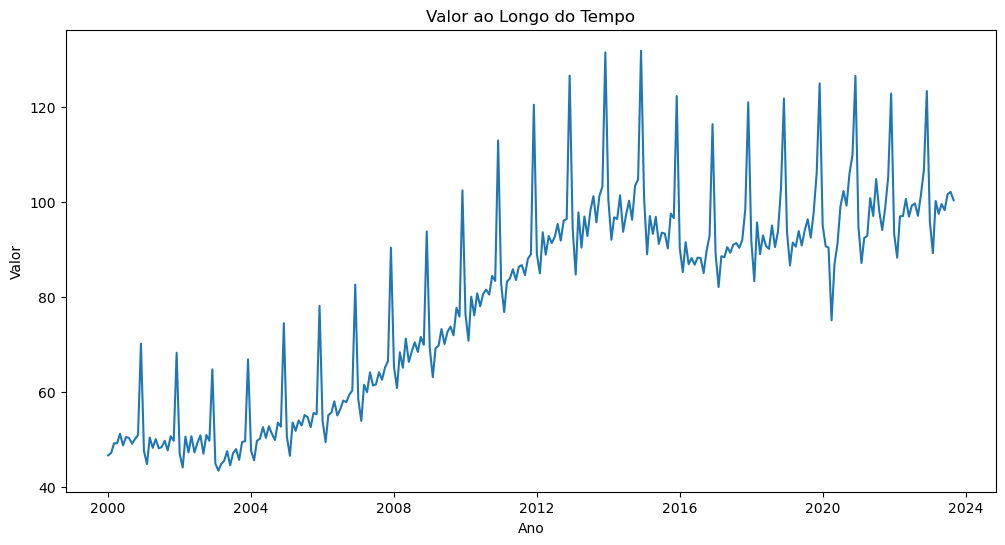

In [66]:
#Plotando a série temporal 
plt.figure(figsize=(12, 6))

plt.plot(df['Mês/ano'], df['Valor'])
plt.title('Valor ao Longo do Tempo')
plt.xlabel('Ano')
plt.ylabel('Valor')

plt.show()

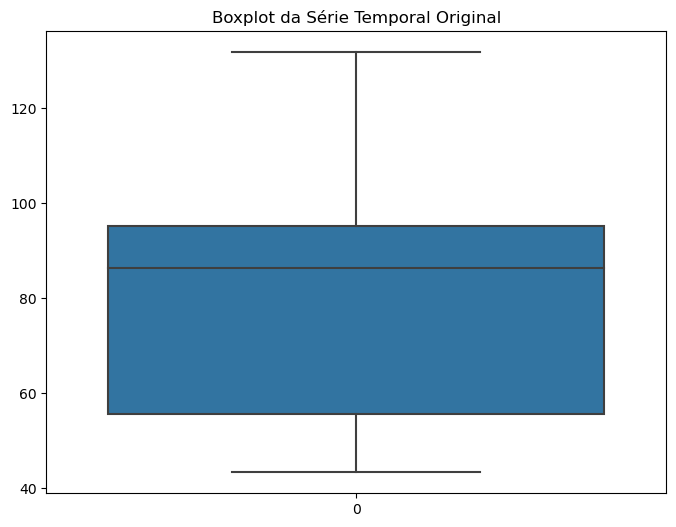

In [67]:
# Boxplot da série temporal original
plt.figure(figsize=(8, 6))
sns.boxplot(data=df['Valor'])  
plt.title('Boxplot da Série Temporal Original')
plt.show()


### Conclusão

Podemos notar que a série aparenta ter amplitude de sazonalidades variando conforme o nível da série, sugerindo uma natureza multiplicativa, ou uma heteroscedasticidade condicional, muito comum em séries financeiras e econômincas.

Vamos conferir as componentes da série temporal e sua natureza através das decomposições aditivas e multiplicativas. Também utilizaremos o método de diferenciação, se necessário, nos dados log transformados.

Aqui vale tambem dizer, que embora não tenhamos aparentemente, outliers quando analisamos a série original como um todo, porém há uma forte mudança no padrão durante o período de janeiro de 2020 a meados de novembro 2020. 

## Decomposição Aditiva

Inicaremos por ela, mesmo sabendo que dificilmente a série possui uma natureza aditiva, visto os padrões de aumento da amplite nas sazonalidades

In [68]:
# Period é a frequência da sazonalidade, usamos period=12 para indicar que o ciclo sazonal é anual e que você espera ver padrões se repetindo a cada 12 meses.
result = seasonal_decompose(df['Valor'], model='additive', period=12)

# Acessar as componentes separadamente
trend = result.trend
seasonal = result.seasonal
residual = result.resid


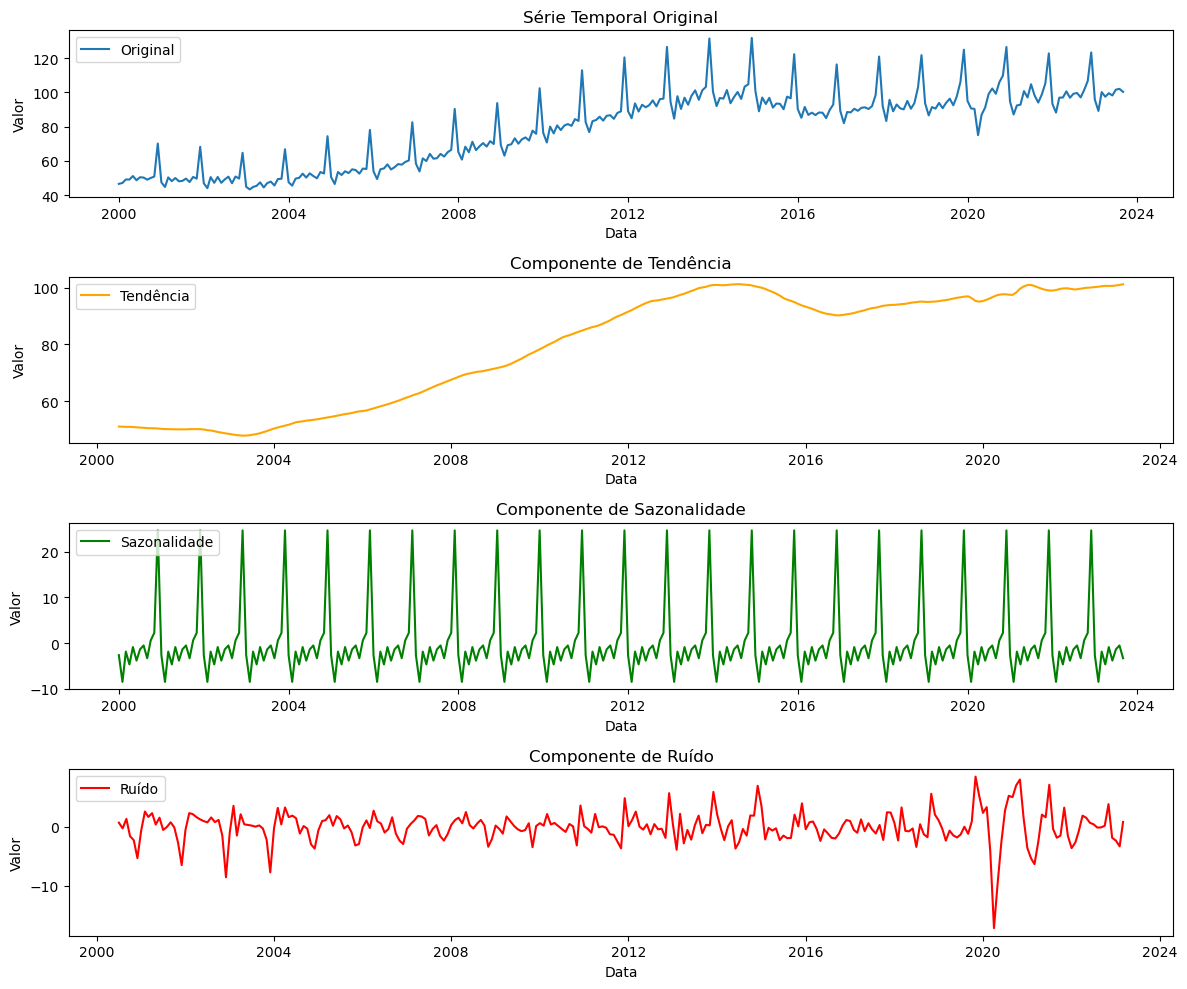

In [69]:
#Plotar a decomposição aditiva

# Criar uma figura e um grid de subgráficos
fig, axes = plt.subplots(4, 1, figsize=(12, 10))

# Plotar a série temporal original
axes[0].plot(df['Mês/ano'], df['Valor'], label='Original')
axes[0].set_title('Série Temporal Original')
axes[0].set_xlabel('Data')
axes[0].set_ylabel('Valor')
axes[0].legend(loc='upper left')

# Plotar a componente de tendência
axes[1].plot(df['Mês/ano'], result.trend, label='Tendência', color='orange')
axes[1].set_title('Componente de Tendência')
axes[1].set_xlabel('Data')
axes[1].set_ylabel('Valor')
axes[1].legend(loc='upper left')

# Plotar a componente de sazonalidade
axes[2].plot(df['Mês/ano'], result.seasonal, label='Sazonalidade', color='green')
axes[2].set_title('Componente de Sazonalidade')
axes[2].set_xlabel('Data')
axes[2].set_ylabel('Valor')
axes[2].legend(loc='upper left')

# Plotar a componente de resíduo
axes[3].plot(df['Mês/ano'], result.resid, label='Ruído', color='red')
axes[3].set_title('Componente de Ruído')
axes[3].set_xlabel('Data')
axes[3].set_ylabel('Valor')
axes[3].legend(loc='upper left')

# Ajustar o layout
plt.tight_layout()
plt.show()

### Conclusão

O ruído da série possui heteroscedasticidade clara, mesmo desconsiderando o período de 2020 referente à COVID-19. Portanto, como já era esperado, a decomposição aditiva não foi capaz de captar as componentes de tendencia e sazonalidade, gerando assim, um ruído que tem sua estacionariedade (fraca) comprometida por essa variância não constante.

## Decomposição Multiplicativa

Vamos utilizar a decomposição multiplicativa, devido a possível natureza da série, uma vez que ela possui heteroscedasticidade, visível nos padrões sazonais, que alteram sua amplitude, aparentemente conforme o nível da série.

In [71]:
# Period é a frequência da sazonalidade, usamos period=12 para indicar que o ciclo sazonal é anual e que você espera ver padrões se repetindo a cada 12 meses.
result = seasonal_decompose(df['Valor'], model='multiplicative', period=12) # Aqui trocamos o model para multiplicative

# Acessar as componentes separadamente
mtrend = result.trend
mseasonal = result.seasonal
mresidual = result.resid

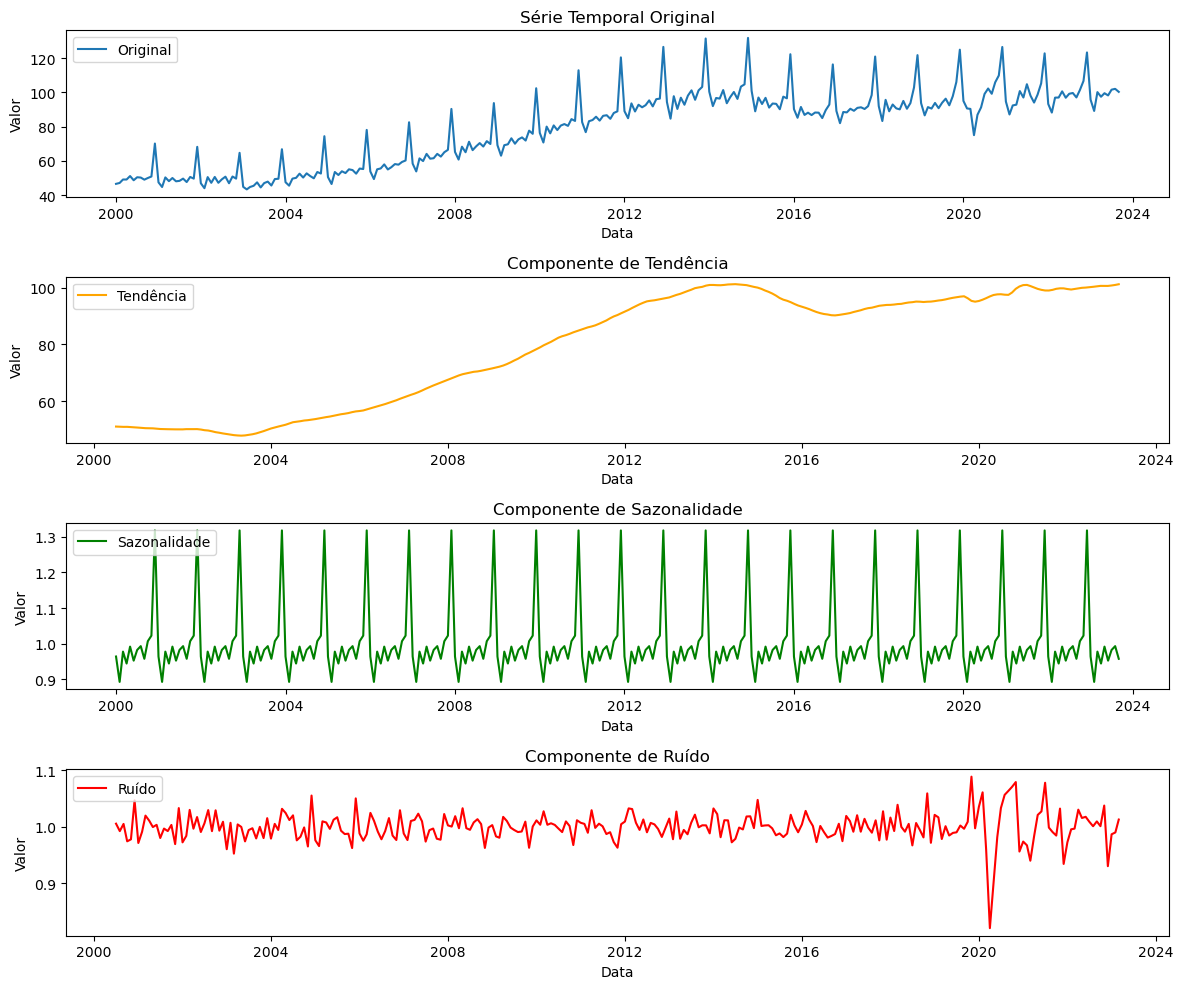

In [72]:
#Plotar a decomposição multiplicativa

# Criar uma figura e um grid de subgráficos
fig, axes = plt.subplots(4, 1, figsize=(12, 10))

# Plotar a série temporal original
axes[0].plot(df['Mês/ano'], df['Valor'], label='Original')
axes[0].set_title('Série Temporal Original')
axes[0].set_xlabel('Data')
axes[0].set_ylabel('Valor')
axes[0].legend(loc='upper left')

# Plotar a componente de tendência
axes[1].plot(df['Mês/ano'], result.trend, label='Tendência', color='orange')
axes[1].set_title('Componente de Tendência')
axes[1].set_xlabel('Data')
axes[1].set_ylabel('Valor')
axes[1].legend(loc='upper left')

# Plotar a componente de sazonalidade
axes[2].plot(df['Mês/ano'], result.seasonal, label='Sazonalidade', color='green')
axes[2].set_title('Componente de Sazonalidade')
axes[2].set_xlabel('Data')
axes[2].set_ylabel('Valor')
axes[2].legend(loc='upper left')

# Plotar a componente de resíduo
axes[3].plot(df['Mês/ano'], result.resid, label='Ruído', color='red')
axes[3].set_title('Componente de Ruído')
axes[3].set_xlabel('Data')
axes[3].set_ylabel('Valor')
axes[3].legend(loc='upper left')

# Ajustar o layout
plt.tight_layout()
plt.show()

### Conclusão 

A decomposição multiplicativa gerou um Ruído com variancia mais homoscedástica, seguindo um intervalo fixo de valores, mentendo sua variancia constante. Porém ainda vemos um impacto muito forte dos outliers, causados pela pandemia de COVID-19 que gerou o fechamento do comércio, e depois uma retomada atípica da economia. Mais especificamente, valores a partir de 2020 mostram um comportamento diferente.


## Método da diferenciação

Vamos analisar os ruídos do método da diferenciação, pois é o método usado no modelo SARIMA. Analisaremos se a diferenciação gera um ruído que seja estacionário.

Para isso, teremos que log transformar os dados, uma vimos através das decomposições que a série segue uma natureza multiplicativa. 

A transformação log transforma uma relação multiplicativa em uma aditiva, o que é importante para a diferenciação.
Se os componentes são multiplicativos, a diferenciação sozinha pode não ser suficiente para remover a sazonalidade e a tendência porque a diferença entre os períodos pode ainda ser proporcional ao nível da série. Por isso, uma transformação logarítmica é frequentemente usada antes da diferenciação, pois ela transforma uma série temporal de natureza multiplicativa em aditiva, facilitando a remoção de componentes indesejados através da diferenciação.

## Método de Diferenciação

### Log transformando os dados

In [74]:
#Adicionando uma coluna no df, com os dados log-transformados
df['Log_Valor'] = np.log(df['Valor'])

In [75]:
# Primeiro, aplicamos a diferenciação sazonal para lidar com a sazonalidade anual
df['Log_Valor_diff'] = df['Log_Valor'].diff(12)

# Em seguida, aplicamos uma segunda diferenciação para remover a tendência
df['Log_Valor_diff_trend'] = df['Log_Valor_diff'].diff()

# Os primeiros 13 valores serão NaN devido à diferenciação
print(df[['Log_Valor', 'Log_Valor_diff', 'Log_Valor_diff_trend']].head(15))

    Log_Valor  Log_Valor_diff  Log_Valor_diff_trend
0    3.840798             NaN                   NaN
1    3.852013             NaN                   NaN
2    3.893876             NaN                   NaN
3    3.893876             NaN                   NaN
4    3.934056             NaN                   NaN
5    3.884923             NaN                   NaN
6    3.920262             NaN                   NaN
7    3.916784             NaN                   NaN
8    3.892091             NaN                   NaN
9    3.911544             NaN                   NaN
10   3.928905             NaN                   NaN
11   4.250016             NaN                   NaN
12   3.859421        0.018623                   NaN
13   3.800524       -0.051489             -0.070112
14   3.918525        0.024649              0.076138


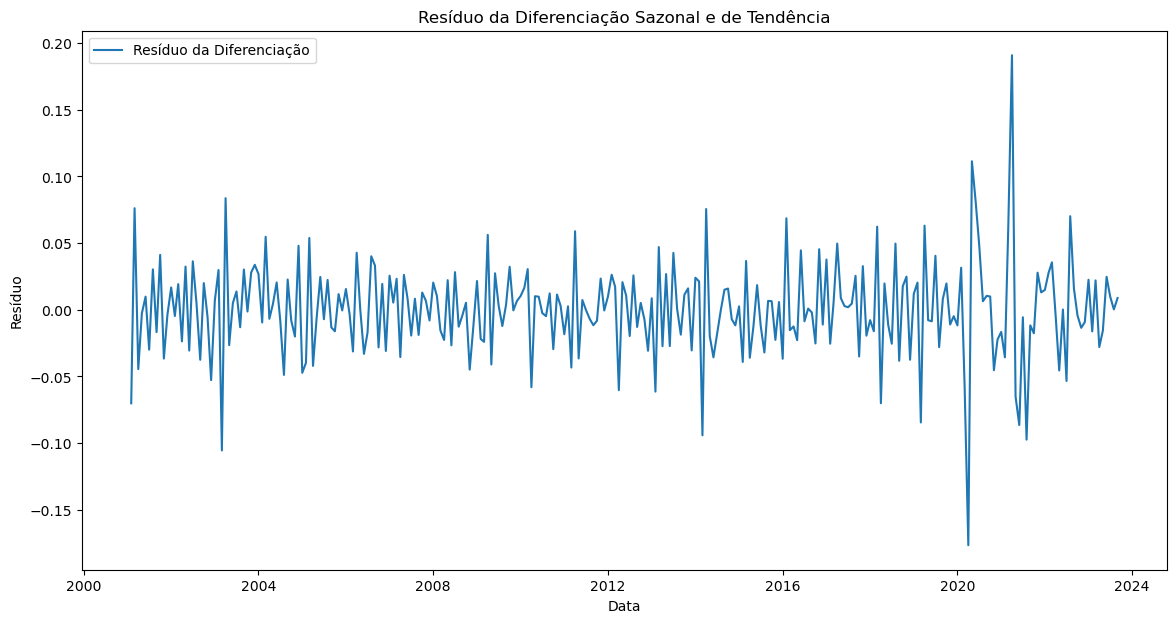

In [76]:
# Plotando o resíduo da diferenciação
plt.figure(figsize=(14, 7))
plt.plot(df['Mês/ano'], df['Log_Valor_diff_trend'], label='Resíduo da Diferenciação')
plt.title('Resíduo da Diferenciação Sazonal e de Tendência')
plt.xlabel('Data')
plt.ylabel('Resíduo')
plt.legend()
plt.show()

## Análise de Estacionariedade dos Ruídos 

Teste de Dickey-Fuller Aumentado (ADF):

Hipótese Nula (H0): A hipótese nula no teste ADF é que a série temporal possui uma raiz unitária, o que significa que a série é não estacionária.

Hipótese Alternativa (H1): A hipótese alternativa é que a série temporal não possui uma raiz unitária, o que sugere que a série é estacionária.

In [78]:
# Teste de Dickey-Fuller para os resíduos da diferenciação de segunda ordem
diff_adf_result = adfuller(df['Log_Valor_diff_trend'].dropna())
print("Resultado do teste de Dickey-Fuller para os resíduos Diferenciação:")
print(f'ADF Statistic: {diff_adf_result[0]}')
print(f'p-value: {diff_adf_result[1]}')
for key, value in diff_adf_result[4].items():
    print(f'Critical Value ({key}): {value}')

Resultado do teste de Dickey-Fuller para os resíduos Diferenciação:
ADF Statistic: -6.0583962986312905
p-value: 1.2292932037250526e-07
Critical Value (1%): -3.4561550092339512
Critical Value (5%): -2.8728972266578676
Critical Value (10%): -2.5728222369384763


#### Tesde ADF do Ruído proveniente da Diferenciação

A estatística ADF (ADF Statistic) é menor do que os valores críticos para todos os níveis de significância (1%, 5%, 10%), indicando que a série de resíduos é estacionária.

O p-valor é muito próximo de zero (1.2292932037250526e-07), sugerindo que podemos rejeitar a hipótese nula de que há uma raiz unitária, o que confirma a estacionariedade.

### Conclusão

O ruído proveninente da diferenciação é considerado estacionário. Portanto seguiremos com ele para mais análises.

## Analisando a normalidade dos ruídos

### QQ-Plot

<Figure size 1400x700 with 0 Axes>

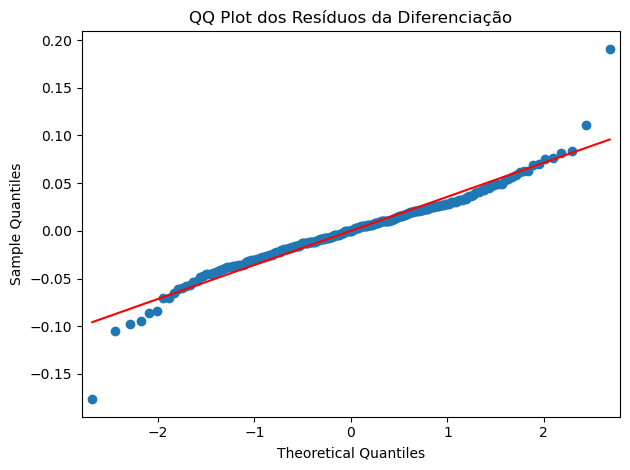

In [79]:
# Criando uma figura com dois subplots lado a lado
plt.figure(figsize=(14, 7))

# QQ plot para os resíduos da diferenciação 
sm.qqplot(df['Log_Valor_diff_trend'].dropna(), line='s',)
plt.title('QQ Plot dos Resíduos da Diferenciação')

plt.tight_layout()
plt.show()

### Teste de Shapiro Wilk

In [80]:
# Teste de Shapiro-Wilk para normalidade dos resíduos da Diferenciação
shapiro_diff_resid = shapiro(df['Log_Valor_diff_trend'].dropna())
print("\nResultado do teste de Shapiro-Wilk para os resíduos da Diferenciação:")
print(f'Statistic: {shapiro_diff_resid[0]}')
print(f'p-value: {shapiro_diff_resid[1]}')


Resultado do teste de Shapiro-Wilk para os resíduos da Diferenciação:
Statistic: 0.9495187997817993
p-value: 4.473635684121291e-08


Estatística do Teste (Statistic): 0.9495

Este valor é um coeficiente que varia de 0 a 1, onde valores mais próximos de 1 indicam que os dados são mais próximos de uma distribuição normal. No caso, 0.9495 sugere uma certa aproximação à normalidade, mas não é suficientemente próximo de 1 para concluir que os dados são normalmente distribuídos.


Valor-p (p-value): 4.47e-08

O valor-p é um indicador de quão extremos são os resultados do teste, dado que a hipótese nula (no caso, que os dados são normalmente distribuídos) é verdadeira. Um valor-p muito baixo sugere que é improvável observar uma estatística de teste tão extrema como a que foi observada se a hipótese nula fosse verdadeira.
Geralmente, um limiar de 0.05 é usado para determinar a significância estatística. Se o valor-p é menor que 0.05, rejeitamos a hipótese nula.
No caso, o valor-p é extremamente baixo (4.47e-08, que é muito menor que 0.05), indicando que os resíduos da diferenciação não seguem uma distribuição normal.

### Conclusão:

O ruído falhou no teste de normalidade de Shapiro Wilk, mas o motivo disso já é conhecido. Temos valores extremos devido a pandemia de COVID-19, e se observarmos no QQ-Plot, são justamente esses pontos que fogem muito de uma distribuição normal. Lembrando que no QQ plot a linha vermelha representa uma distribuição normal perfeita.

Em todo caso, consideraremos aproximadamente normal e trataremos esses pontos ao rodarmos modelos.

# 3 - Pré-processamento

## Rodando e Plotando as Funções de Autocorrelação e Autocorrelação Parcial

Estas funções são essenciais para analisar a relação entre pontos de dados em diferentes lags (intervalos de tempo). 
A função de Autocorrelação (ACF) mostra a correlação de uma série temporal com suas próprias versões atrasadas, enquanto a função de Autocorrelação Parcial (PACF) fornece a correlação parcial de uma série com suas próprias versões atrasadas, controlando por outros lags. Essa análise nos ajuda a identificar os parâmetros AR(p) e MA(q) para o modelo SARIMA. 

O parâmetro AR(p) representa a ordem do componente AutoRegressivo, indicando o número de lags relevantes para prever o valor atual, e o MA(q) representa a ordem do componente de Médias Móveis, refletindo o número de erros de previsão passados que influenciam o valor atual.


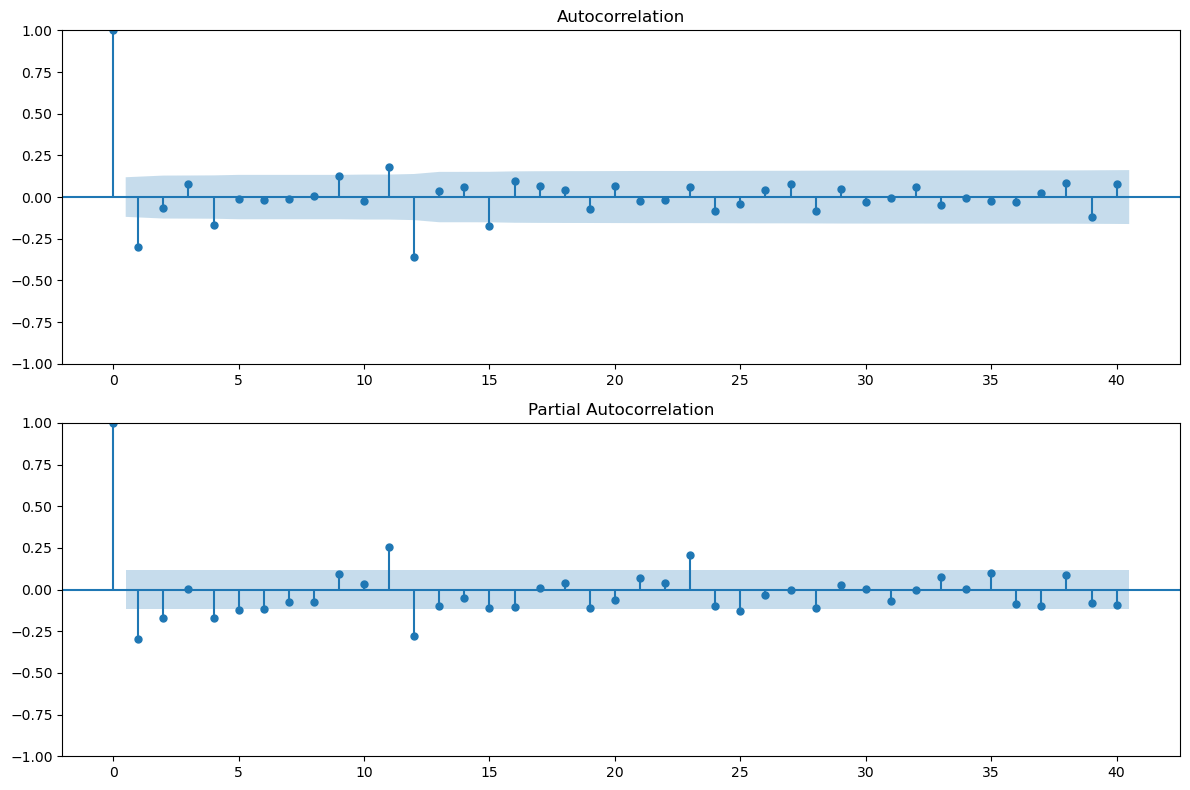

In [81]:
# Plotando ACF e PACF para os resíduos da diferenciação
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

plot_acf(df['Log_Valor_diff_trend'].dropna(), lags=40, ax=ax1)
plot_pacf(df['Log_Valor_diff_trend'].dropna(), lags=40, ax=ax2, method='ywm')

plt.tight_layout()
plt.show()

### Conclusão

Aqui podemos ter uma ideia dos parâmetros de AR(p) e MA(q).

A ACF - Função de Autocorrelação:
Parece haver uma autocorrelação no lag = 1 referente ao modelo ARIMA e uma possível autocorrelação de 1 ou 0 no SARIMA.

A PACF - Função de Autocorrelação Parcial
Parece haver uma autocorrelação no lag = 1 referente ao modelo ARIMA e uma possível autocorrelação de 1 ou 0 no SARIMA.

Mas testaremos no modelo alguns parâmetros.

# 4 - Construção do Modelo SARIMA

## Modelo SARIMA 

In [82]:
#Separando em treino e teste
train_size = int(len(df['Log_Valor']) * 0.8)
train, test = df[:train_size], df[train_size:]

In [83]:
# Definição dos parâmetros do modelo SARIMA
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 12)

# Criação e ajuste do modelo SARIMA
model = SARIMAX(train['Log_Valor'], order=order, seasonal_order=seasonal_order)
results = model.fit()

# Exibição do resumo do modelo
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                          Log_Valor   No. Observations:                  228
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 511.747
Date:                            Wed, 22 Nov 2023   AIC                          -1013.493
Time:                                    17:16:13   BIC                           -996.640
Sample:                                         0   HQIC                         -1006.684
                                            - 228                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3471      0.128     -2.712      0.007      -0.598      -0.096
ma.L1         -0.3065      0.118   

## Otimização dos Parâmetros AR(p) e MA(q) do Modelo SARIMA

A seguir, realizaremos a seleção dos parâmetros para o modelo SARIMA com o objetivo de encontrar a configuração que resulta no menor valor do Critério de Informação de Akaike (AIC). O AIC é um indicador utilizado para comparar modelos, levando em conta não apenas o ajuste do modelo aos dados, mas também a penalização por qualquer aumento na complexidade do modelo. Um valor menor de AIC indica um modelo mais preferível, equilibrando a precisão e a simplicidade.

### Modelo com melhor valor de AIC

In [84]:
# Definição dos parâmetros do modelo SARIMA
order = (1, 1, 3)
seasonal_order = (1, 1, 1, 12)

# Criação e ajuste do modelo SARIMA
model = SARIMAX(train['Log_Valor'], order=order, seasonal_order=seasonal_order)
results = model.fit()

# Exibição do resumo do modelo
print(results.summary())

                                      SARIMAX Results                                       
Dep. Variable:                            Log_Valor   No. Observations:                  228
Model:             SARIMAX(1, 1, 3)x(1, 1, [1], 12)   Log Likelihood                 518.823
Date:                              Wed, 22 Nov 2023   AIC                          -1023.646
Time:                                      17:16:14   BIC                          -1000.052
Sample:                                           0   HQIC                         -1014.113
                                              - 228                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4104      0.372     -1.103      0.270      -1.139       0.319
ma.L1         -0.28

## Análise de ruídos

Ljung-Box (L1) (Q): Este teste verifica a autocorrelação residual nos dados. Um valor próximo de zero (como 0.00) sugere que não há autocorrelação significativa nos resíduos, o que é bom.

Prob(Q): É o p-valor associado ao teste Ljung-Box. Um valor alto (como 0.95) significa que não há evidência estatística de autocorrelação nos resíduos a esse nível.

Jarque-Bera (JB): Este teste verifica se os resíduos têm uma distribuição normal. Um valor baixo de JB (como 4.12) sugere que os resíduos são aproximadamente normais.

Prob(JB): É o p-valor para o teste Jarque-Bera. Um valor alto (como 0.13) significa que não podemos rejeitar a hipótese de normalidade dos resíduos.

Heteroskedasticity (H): Este valor testa a homogeneidade dos resíduos (se a variância dos resíduos é constante ao longo do tempo). Um valor próximo de 1 (como 0.96) sugere que não há heteroscedasticidade significativa.

Prob(H) (two-sided): É o p-valor para o teste de heteroscedasticidade. Um valor alto (como 0.85) sugere que não há evidência estatística de heteroscedasticidade nos resíduos.

Skew: Mede a assimetria dos resíduos. Um valor próximo de 0 (como -0.34) sugere que a distribuição dos resíduos é aproximadamente simétrica.

Kurtosis: Mede o achatamento da distribuição dos resíduos em comparação com uma distribuição normal. Uma curtose próxima de 3 (como 2.96) é esperada para uma distribuição normal.

## Análise visual dos Resíduos

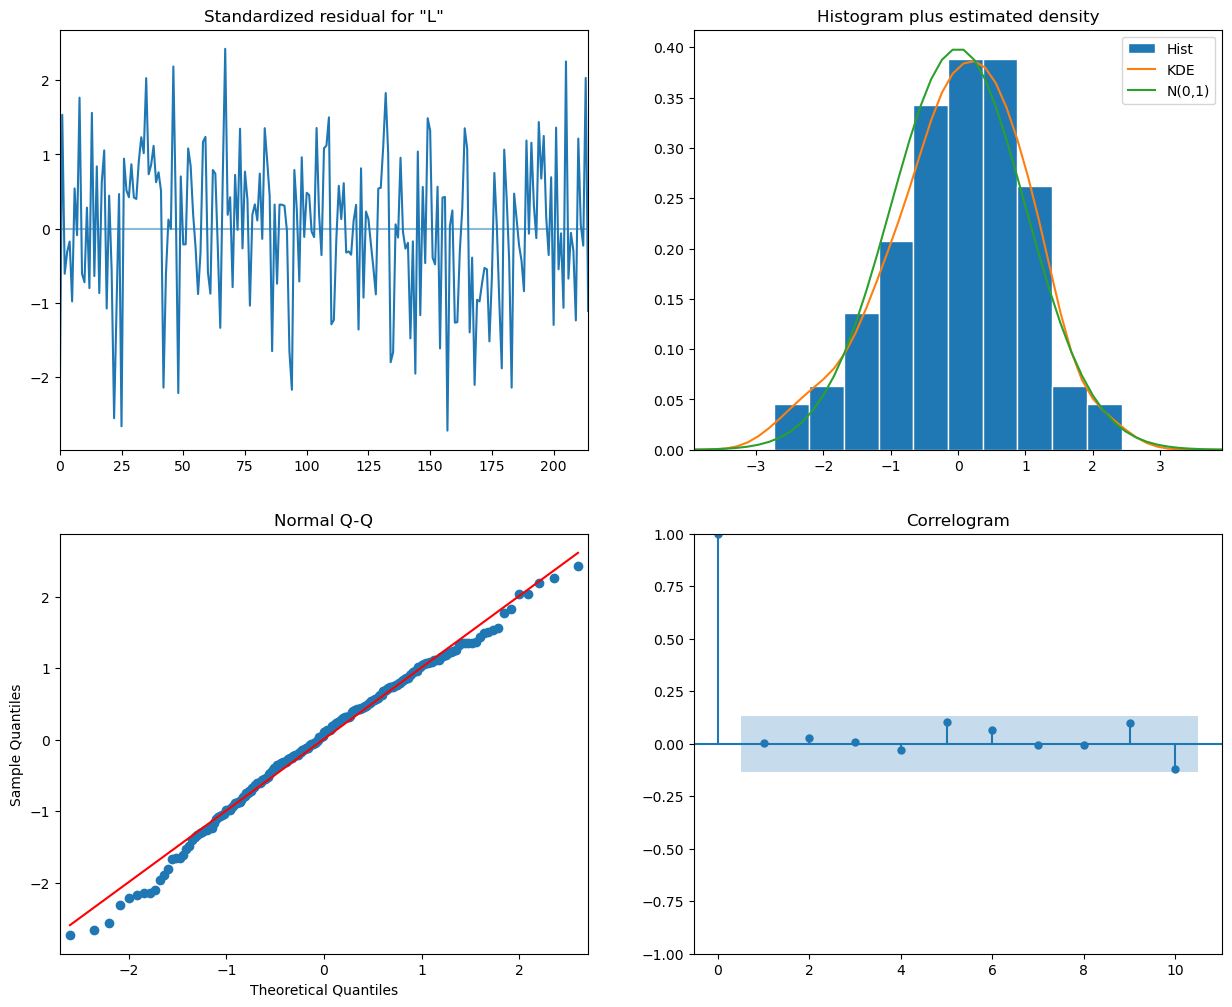

In [85]:
# # Diagnóstico do modelo
results.plot_diagnostics(figsize=(15, 12))
plt.show()

### Conclusão

A análise dos resíduos do modelo SARIMA ajustado indica que estamos lidando com um Ruído Branco Gaussiano. Isso implica que os resíduos do nosso modelo são desprovidos de autocorrelações significativas (tanto na ACF quanto na PACF), sugerindo que o modelo capturou efetivamente a estrutura de dependência temporal dos dados. 

Adicionalmente, os resíduos seguem uma distribuição normal com média zero, o que é consistente com as premissas de um modelo bem ajustado. Tais características de ruído branco nos resíduos são indicativas de que o modelo SARIMA se ajusta bem aos dados e que a variabilidade restante é aleatória e não previsível, que é o comportamento desejado dos resíduos de um modelo de séries temporais robusto e confiável.


# 5 - Avaliação do Modelo

## Rodando o modelo nos dados de teste

In [86]:
#número de observações que tem em 'test'
n_forecasts = len(test)

# Fazendo as previsões
forecast_results = results.get_forecast(steps=n_forecasts)

# Obtendo as previsões e os intervalos de confiança
predicted_mean = forecast_results.predicted_mean
conf_int = forecast_results.conf_int()

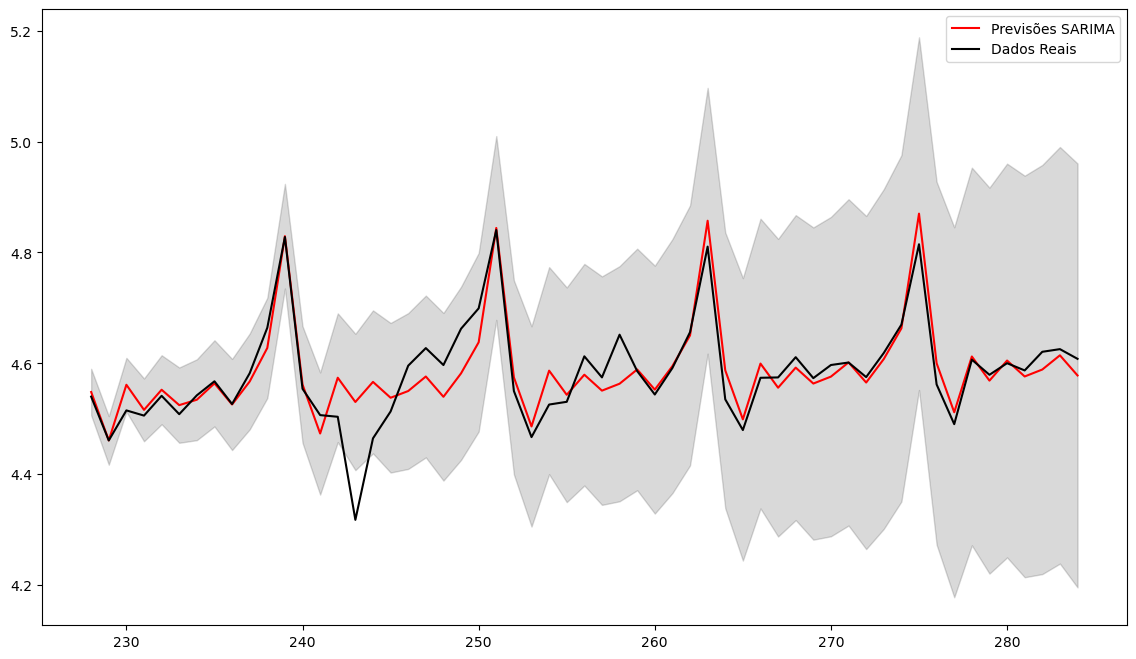

In [87]:
plt.figure(figsize=(14, 8))

# Linha de previsões
plt.plot(predicted_mean, label='Previsões SARIMA',color='red' )

# Área do intervalo de confiança
plt.fill_between(conf_int.index, 
                 conf_int.iloc[:, 0], 
                 conf_int.iloc[:, 1], 
                 color='k', alpha=.15)

# Adicionar dados reais para comparação
plt.plot(test['Log_Valor'], label='Dados Reais', color='black')

plt.legend()
plt.show()

### Conclusão

Aqui claramente uma previsão de muitos periodos a frente. O problema dessa abordagem, é que a primeira previsão fora da amostra é baseada no último ponto conhecido do conjunto de dados de treino, mas para fazer a próxima previsão, o modelo utiliza a previsão que acabou de ser feita anteriormente como se fosse um dado real. Essa abordagem é repetida para cada novo ponto que você quer prever.

Cada previsão é, portanto, uma atualização incremental baseada nas previsões anteriores e não nos dados reais.
Por essa razão, o intervalo de confiança (parte cinza do gráfico) tende a se alargar à medida que as previsões se estendem mais para o futuro, refletindo a acumulação de incerteza e a potencial amplificação dos erros de previsão.

Assim, mesmo que o modelo tenha sido treinado com dados reais até um certo ponto, para previsões futuras, ele depende de suas próprias previsões como entrada, já que não há mais dados reais disponíveis nesse horizonte de previsão.

## Calculando Erro

Aqui nós usaremos:

**MSE (Mean Squared Error)**
O MSE é a média dos quadrados dos erros. É semelhante ao RMSE, mas sem a raiz quadrada.  
***Interpretação:*** O MSE é útil para análises matemáticas e computacionais, pois é diferenciável e facilita a otimização de algoritmos. Como o RMSE, ele dá mais peso a erros maiores. Um valor baixo de MSE indica um bom ajuste do modelo, mas seu valor é menos intuitivo para interpretação, pois não está na mesma escala dos dados.


**RMSE (Root Mean Squared Error)**
É a raiz quadrada da média dos quadrados dos erros. É uma medida que dá maior peso a erros maiores.  
***Interpretação:*** O RMSE é útil quando grandes erros são particularmente indesejáveis. Ele é sensível a outliers, pois os erros maiores são elevados ao quadrado antes de serem médios, o que aumenta sua influência no valor final. Um RMSE baixo indica um bom ajuste do modelo, especialmente em contextos onde erros maiores são mais problemáticos do que muitos pequenos erros.


**MAE (Mean Absolute Error)**
O que é: O MAE é a média dos valores absolutos dos erros. Ele mede a diferença média entre os valores previstos e os valores observados.  
***Interpretação:*** O MAE é uma medida mais direta e intuitiva dos erros médios. Diferente do RMSE, o MAE não dá um peso desproporcional para erros maiores, tornando-o útil em situações onde todos os erros são igualmente importantes. Um valor baixo de MAE indica que o modelo tem um bom desempenho em média, com erros pequenos.


**Considerações Gerais**
RMSE e MSE são mais diretamente comparáveis entre si, enquanto o MAE está em uma escala diferente. Por exemplo, um MAE pode parecer artificialmente menor que um RMSE, mas isso não significa necessariamente um desempenho melhor.

In [88]:
# Calculando os erros de todos os valores previstos
errors = test['Log_Valor'] - predicted_mean

# Calculando o MSE
mse = np.mean(errors ** 2)

# Calculando o RMSE
rmse = np.sqrt(mse)

# Calculando o MAE
mae = np.mean(np.abs(errors))

print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)


MSE: 0.0020007299817298755
RMSE: 0.04472952024927023
MAE: 0.02895967706149345


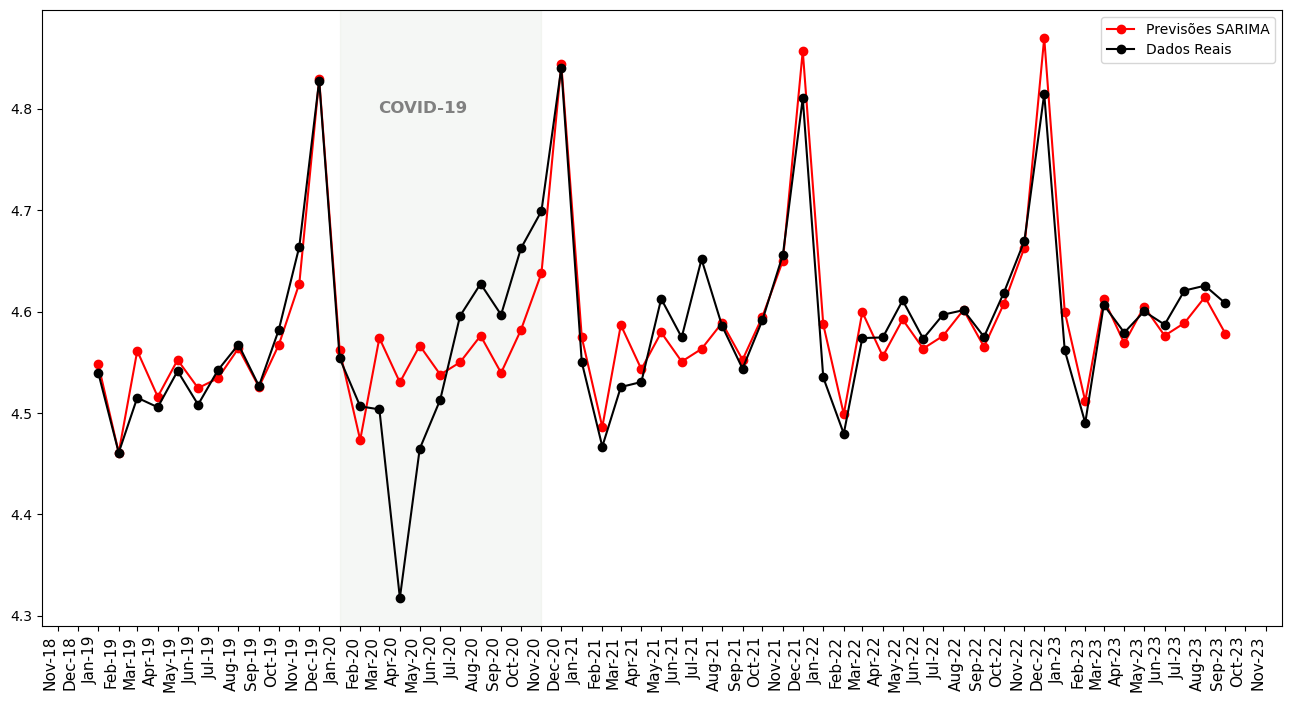

In [89]:
fig, ax = plt.subplots(figsize=(16, 8))

# Plotar a linha de previsões
ax.plot(df['Mês/ano'][228:],predicted_mean, label='Previsões SARIMA', marker='o', color='red')

# Plotar a linha de dados reais
ax.plot(df['Mês/ano'][228:],test['Log_Valor'], label='Dados Reais', marker='o', color='black')

#Definir o localizador de meses para cada mês e o formatador para o formato 'Ano-Mês'
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))

# Girar as etiquetas do eixo x para melhor visualização, se necessário
plt.setp(ax.get_xticklabels(), rotation=90, ha='right', fontsize=11)


plt.axvspan(df['Mês/ano'][240], df['Mês/ano'][250], color='#E0E6DE', alpha=0.3)
ax.annotate("COVID-19", 
            (df['Mês/ano'][244],4.8),  # Ajuste estas coordenadas para onde você quer a anotação
            ha="center", 
            va="center",
            xytext=(2, 0), 
            textcoords="offset points", 
            fontsize=12, 
            fontweight='bold',
            color="gray"
           )



ax.legend()
plt.show()

### Conclusão:

Essa previsão gerou os seguintes valores de erro:

**RMSE:** 0.04472952024927023  
**MAE:** 0.02895967706149345  
**MSE:** 0.0020007299817298755  

No gráfico vemos um impacto significativo no erro no período da Covid-19 e consequentemente o fechamento do comércio. É um ponto de atenção, pois uma vez que o modelo não foi treinado com essa variável exógena, ele pode apresentar problemas, quando formos para um teste mais robusto, ou até mesmo no uso do dia a dia. 

Afim de testar o modelo de uma forma mais robusta e compatível com seu real uso, vamos utilizar o Walk Forward.

## Usando o Walk Forward

Neste método, os dados são divididos em um conjunto de treino e um conjunto de teste. O modelo é treinado no conjunto de treino e faz uma previsão para o próximo ponto no conjunto de teste. Então, o modelo é atualizado ou re-treinado com esse ponto de teste (agora como parte do conjunto de treino) e faz uma nova previsão para o próximo ponto no conjunto de teste, e assim sucessivamente.

Assim, a cada passo, os dados reais são incorporados ao modelo para as previsões futuras, o que pode ajudar a melhorar a precisão das previsões, já que o modelo está sempre sendo alimentado com os dados mais recentes disponíveis.

In [90]:
# # Ajustando o modelo SARIMA usando a abordagem de movimento "walk-forward"

#Separando em treino e teste
train_size = int(len(df['Log_Valor']) * 0.8)
train, test = df[:train_size], df[train_size:]

predictions = []
observed = []
for t in range(len(test)):
    exog = None  
    model = SARIMAX(train['Log_Valor'], order=order, seasonal_order=seasonal_order, exog=exog)
    results = model.fit(maxiter=2000) #Limitando o numero de iterações, para encontrar o valor ótimo de MLE
    
    forecast = results.get_forecast(steps=1)
    predicted_value = forecast.predicted_mean.iloc[0]
    
    actual_value = test.iloc[t]['Log_Valor']
    predictions.append(predicted_value)
    observed.append(actual_value)
    
    train = pd.concat([train, test[t:t+1]])  # Atualiza a janela de treinamento
    
# Calculando o RMSE
rmse = mean_squared_error(observed, predictions, squared=False)
print("RMSE:", rmse)

C:\Users\feborges\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\feborges\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RMSE: 0.05014605801496774


## Problemas de convergencia do modelo

Quando fomos rodar o modelo, afim de testar sua capacidade e usabilidade, com o método Walk Forward, vimos que em alguns casos ele não converge para o metodo de otimização de Máxima Similhança (MLE). 

Isso ocorre devido as mudanças abruptas de padrões que temos na série orignal, ocasionados pelo COVID-19 como já vimos anteriormente.

Para solucionar esse problema, vamos utilizar a variavel exog no modelo SARIMA, afim de passar a info da alteração do padrão, para o modelo. E com isso veremos se o modelo consegue convergir.

## Walk Forward com variável exógena definida

Aqui foi definido uma variável exógena passando para o modelo os meses em que houve uma mudança atípica do padrão dos dados.

In [91]:
# Definindo a variavel Dummy referente ao período da COVID-19
df['Covid_Impact'] = 0  # Inicializa a coluna com 0
df.loc[241:249, 'Covid_Impact'] = 1  # Define como 1 a partir do índice 241

In [92]:
# # Ajustando o modelo SARIMA usando a abordagem de movimento "walk-forward"

#Separando em treino e teste
train_size = int(len(df['Log_Valor']) * 0.8)
train, test = df[:train_size], df[train_size:]

predictions = []
observed = []
for t in range(len(test)):
    # Incluindo a variável exógena no treinamento
    exog = train[['Covid_Impact']]
    
    model = SARIMAX(train['Log_Valor'], order=order, seasonal_order=seasonal_order, exog=exog)
    results = model.fit(maxiter=3000) # usando a mesma limitação de iterações
    
    # Incluindo a variável exógena na previsão
    exog_forecast = test.iloc[t:t+1][['Covid_Impact']]  # Ajuste para selecionar a linha correta

    forecast = results.get_forecast(steps=1, exog=exog_forecast)
    predicted_value = forecast.predicted_mean.iloc[0]
    
    actual_value = test.iloc[t]['Log_Valor']
    predictions.append(predicted_value)
    observed.append(actual_value)
    
    # Atualiza a janela de treinamento
    train = pd.concat([train, test.iloc[t:t+1]])
    

# Calculando o RMSE
rmse = mean_squared_error(observed, predictions, squared=False)
print("RMSE:", rmse)

RMSE: 0.05128589639044222


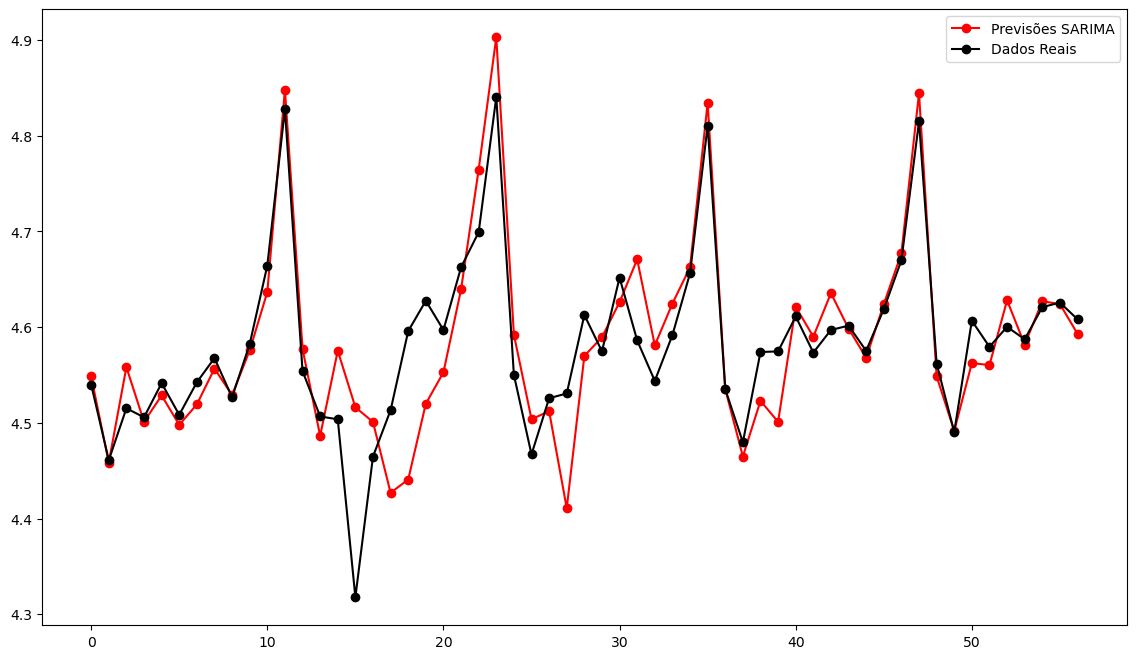

In [93]:
#Criar o plot
fig, ax = plt.subplots(figsize=(14, 8))

# Plotar a linha de previsões
ax.plot(predictions, label='Previsões SARIMA', marker='o', color='red')

# Plotar a linha de dados reais
ax.plot(observed, label='Dados Reais', marker='o', color='black')

ax.legend()
plt.show()

Obtivemos um RSME um pouco maior, porém agora o modelo convergiu e econtrou os valores ótimos de MLE. 
Portanto, o modelo é agora confiável e possui um **RMSE de 0.05128589639044222.**

Vamos converter os valores log transformados para valores reais 

## Convertendo para os valores reais

In [94]:
# Reverter a transformação logarítmica
predictions_real = np.exp(predictions)
observed_real = np.exp(observed)

# Calculando o RMSE nos valores reais
rmse_real = mean_squared_error(observed_real, predictions_real, squared=False)
print("RMSE nos valores reais:", rmse_real)

RMSE nos valores reais: 4.781860633035403


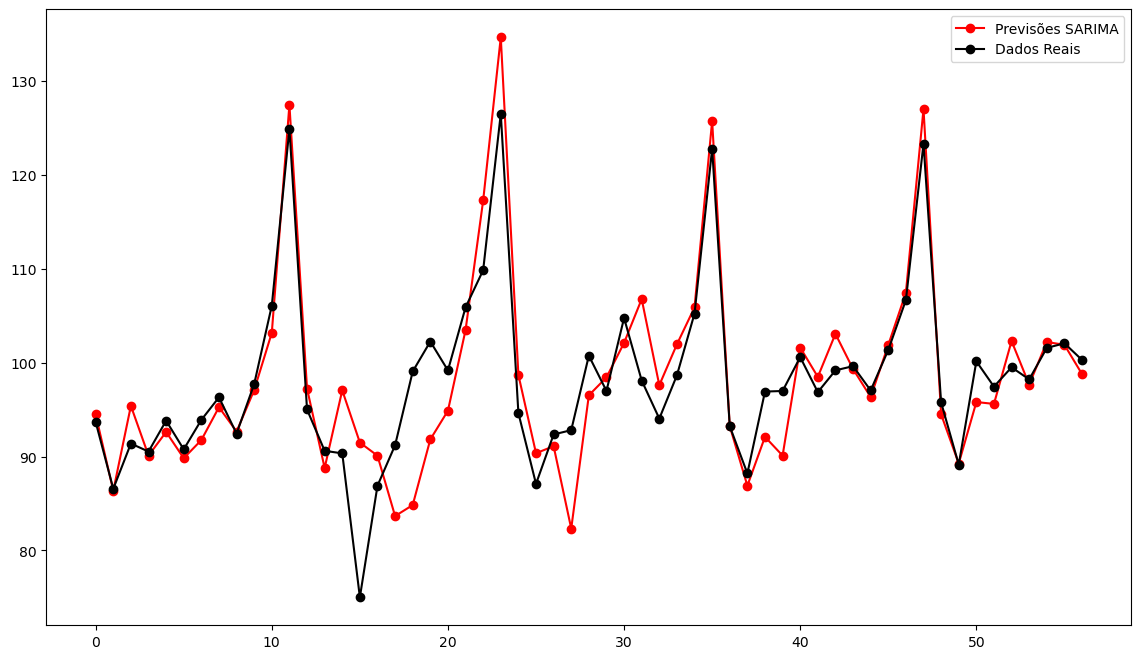

In [95]:
# Criar a figura e o eixo para plotagem
fig, ax = plt.subplots(figsize=(14, 8))

# Plotar a linha de previsões na escala original
ax.plot(predictions_real, label='Previsões SARIMA', marker='o', color='red')

# Plotar a linha de dados reais na escala original
ax.plot(observed_real, label='Dados Reais', marker='o', color='black')


# Adicionar legenda e mostrar o gráfico
ax.legend()
plt.show()


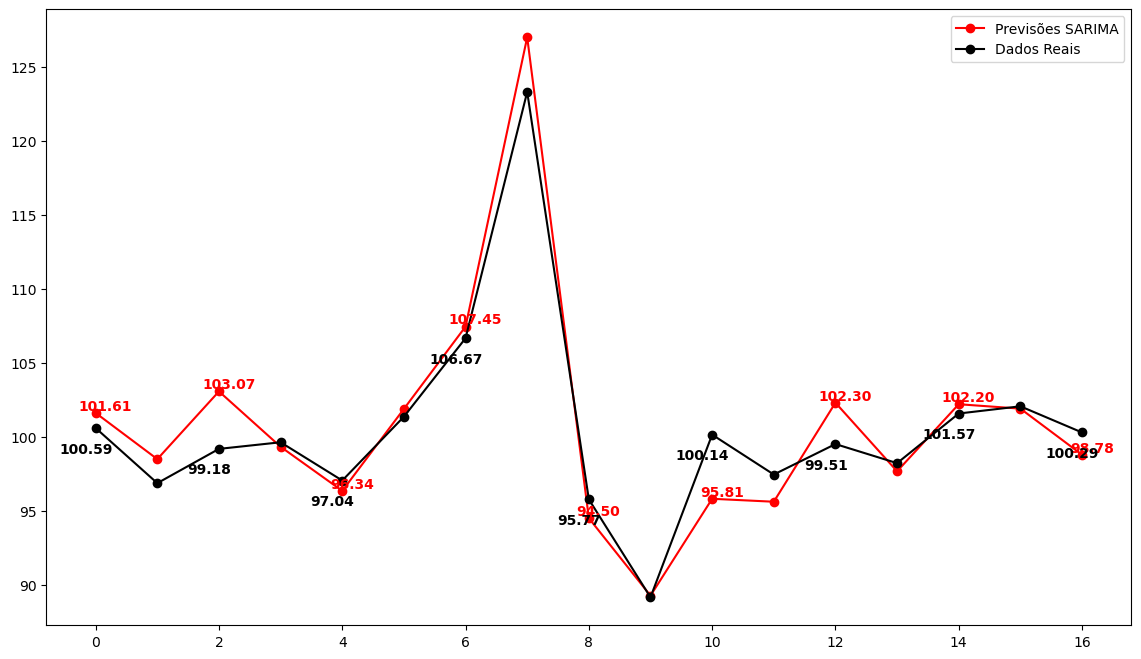

In [96]:
# Criar a figura e o eixo para plotagem
fig, ax = plt.subplots(figsize=(14, 8))

# Plotar a linha de previsões na escala original
ax.plot(predictions_real[40:], label='Previsões SARIMA', marker='o', color='red')

# Plotar a linha de dados reais na escala original
ax.plot(observed_real[40:], label='Dados Reais', marker='o', color='black')


# Adicionar anotações para dados reais a cada 2 pontos
for i, value in enumerate(predictions_real[40:]):
    if i % 2 == 0:  # Isso garante que estamos anotando a cada 2 pontos
        ax.annotate(f'{value:.2f}',
                    (df.index[i], value), # Alinhamento horizontal do texto
                    ha="center",  # Alinhamento horizontal do texto
                    va="top", # Alinhamento vertical do texto
                    xytext=(7, 10), # Deslocamento em relação ao ponto que o texto estaria
                    textcoords="offset points",  # Sistema de coordenadas que o xytext vai ter como referência (nesse caso será em pontos, não em pixels)
                    fontsize=10, # Tamanho da fonte dos rótulos
                    fontweight='bold', # Espessura da fonte dos rótulos
                    color="red")


# Adicionar anotações para dados reais a cada 2 pontos
for i, value in enumerate(observed_real[40:]):
    if i % 2 == 0:  # Isso garante que estamos anotando a cada 2 pontos
        ax.annotate(f'{value:.2f}',
                    (df.index[i], value),  # Alinhamento horizontal do texto
                    ha="center",  # Alinhamento horizontal do texto
                    va="top", # Alinhamento vertical do texto
                    xytext=(-7, -10), # Deslocamento em relação ao ponto que o texto estaria
                    textcoords="offset points", # Sistema de coordenadas que o xytext vai ter como referência (nesse caso será em pontos, não em pixels)
                    fontsize=10, # Tamanho da fonte dos rótulos
                    fontweight='bold', # Espessura da fonte dos rótulos
                    color="black")     
        
        
# Adicionar legenda e mostrar o gráfico
ax.legend()
plt.show()

### Conclusão

Agora, com os valores reais, temos um **RMSE de 4.781860633035403**. Isso significa que nosso erro médio foi de 4.78 pontos de diferença do valor real, incluindo aí o período de COVID- 19. 

# 6 - Realizando e visualizando as Previsões

## Prevendo os próximos 12 meses

In [97]:
#Treinando o modelo novamente

# Definindo a variavel Dummy referente ao período da COVID-19
df['Covid_Impact'] = 0  # Inicializa a coluna com 0
df.loc[241:249, 'Covid_Impact'] = 1  # Define como 1 a partir do índice 241

exog = df[['Covid_Impact']]

model = SARIMAX(df['Log_Valor'], order=order, seasonal_order=seasonal_order, exog=exog)
results = model.fit(maxiter=3000) # usando a mesma limitação de iterações

In [98]:
# Criando um novo DataFrame para a variável exógena com o valor 0 para os próximos 12 meses
next_point_exog = pd.DataFrame([0]*12, columns=['Covid_Impact'])

# Fazendo a previsão para os próximos 12 meses com a variável exógena Covid_Impact definida como 0
forecast = results.get_forecast(steps=12, exog=next_point_exog)

# Obtendo as previsões e os intervalos de confiança
predicted_means = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Reverter as previsões log-transformadas para a escala original
predicted_means_real = np.exp(predicted_means)
confidence_intervals_real = np.exp(confidence_intervals)

# Obter datas dos próximos 12 meses
last_date = df['Mês/ano'].iloc[-1]
N = 12
next_months = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=N, freq='MS')



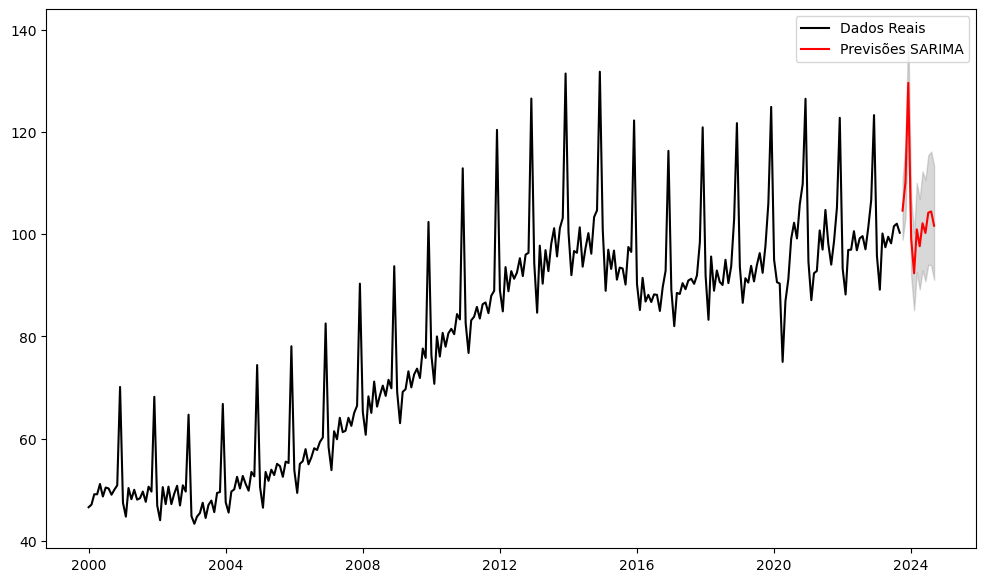

In [99]:
# Certificando-se de que ' a coluna 'Mês/ano' está no formato correto de data
df['Mês/ano'] = pd.to_datetime(df['Mês/ano'])

# Plotar os dados existentes
plt.figure(figsize=(12, 7))
plt.plot(df['Mês/ano'], np.exp(df['Log_Valor']), label='Dados Reais', color='black')

# Plotar as previsões e conectar com linhas
plt.plot(next_months, predicted_means_real, color='red', label='Previsões SARIMA')

# Plotar os intervalos de confiança
plt.fill_between(next_months, 
                 confidence_intervals_real['lower Log_Valor'], 
                 confidence_intervals_real['upper Log_Valor'], 
                 color='gray', alpha=0.3)

plt.legend()

plt.show()

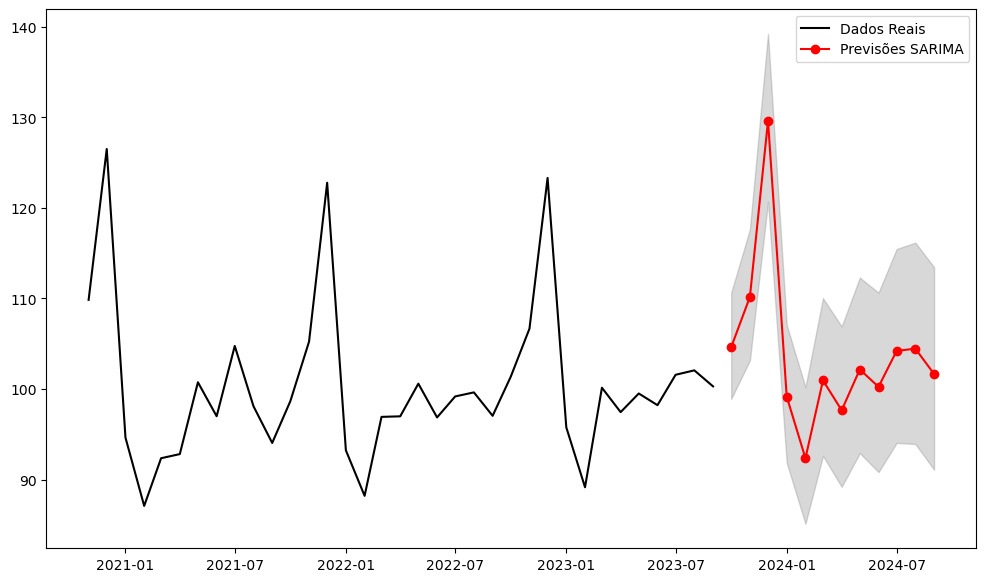

In [100]:
# Plotar os dados existentes
plt.figure(figsize=(12, 7))
plt.plot(df['Mês/ano'][250:], np.exp(df['Log_Valor'][250:]), label='Dados Reais', color='black')

# Plotar as previsões e conectar com linhas
plt.plot(next_months, predicted_means_real, color='red', label='Previsões SARIMA', marker='o')

# Plotar os intervalos de confiança
plt.fill_between(next_months, 
                 confidence_intervals_real['lower Log_Valor'], 
                 confidence_intervals_real['upper Log_Valor'], 
                 color='gray', alpha=0.3)

plt.legend()

plt.show()

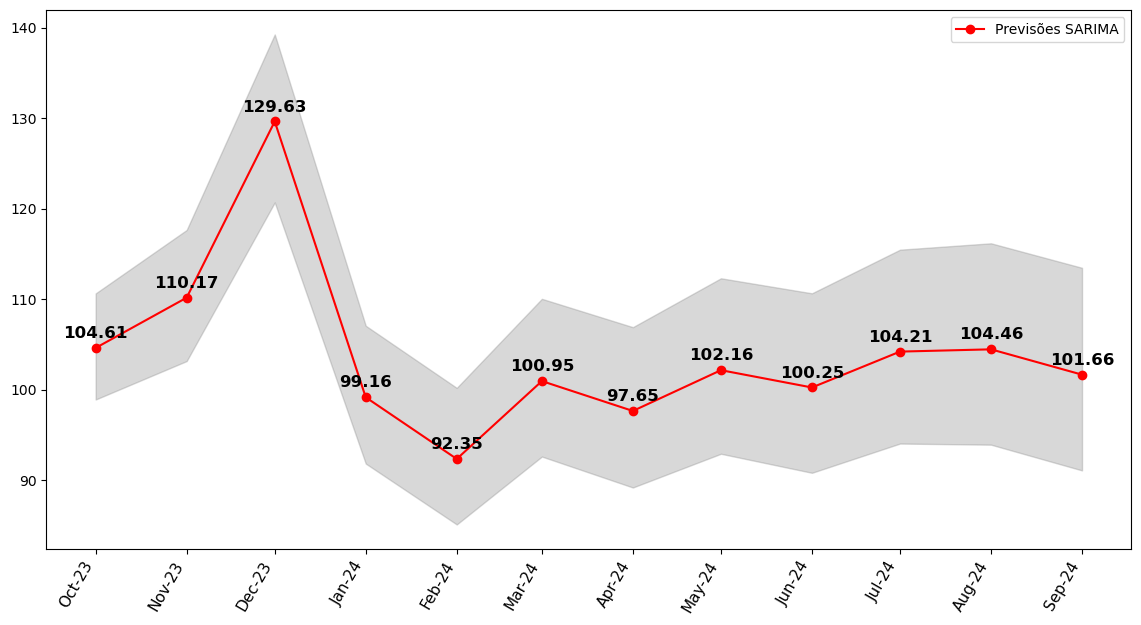

In [101]:
# Criando a figura e os eixos
fig, ax = plt.subplots(figsize=(14, 7))

# Plotar as previsões e conectar com linhas
plt.plot(next_months, predicted_means_real, color='red', label='Previsões SARIMA', marker='o')

# Plotar os intervalos de confiança
plt.fill_between(next_months, 
                 confidence_intervals_real['lower Log_Valor'], 
                 confidence_intervals_real['upper Log_Valor'], 
                 color='gray', alpha=0.3)


for date, value in zip(next_months, predicted_means_real):
    ax.annotate(f'{value:.2f}', xy=(mdates.date2num(date), value), xycoords='data',
                ha="center", va="bottom", xytext=(0, 5), textcoords="offset points",
                fontsize=12, fontweight='bold', color="black")



# Formatar o eixo x para mostrar as datas corretamente
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
ax.xaxis.set_major_locator(mdates.MonthLocator())




# Girar as etiquetas do eixo x para melhor visualização, se necessário
plt.setp(ax.get_xticklabels(), rotation=60, ha='right', fontsize=11)

    
plt.legend()

plt.show()

### Conclusão

Aqui foi previsto os próximos 12 meses. A faixa cinza representa o intervalo de confiança sob os valores previstos, perceba que ele vai aumentando conforme as previsões vão ficando mais distantes. Portanto, previsões mais longas, tendem a ser menos precisas.

De modo geral o modelo responde bem, e gera resultados satisfatórios para os padrões deste trabalho.

# 7 - Conclusões

Neste estudo, aplicamos um modelo SARIMA para prever o volume do comércio, levando em consideração os impactos significativos da pandemia de COVID-19, que foram incorporados no modelo como uma variável exógena. A heteroscedasticidade, uma característica comum em dados econômicos, foi observada e abordada através da transformação logarítmica para estabilizar a variância ao longo da série temporal.

**Métodos de Validação**:  
Empregamos duas abordagens distintas para a validação do modelo: o método de divisão de treino e teste tradicional e a técnica de Walk Forward. A técnica de Walk Forward, particularmente, nos revelou que o modelo não convergia para o valor ótimo do MLE Máxima Verossimilhança Estimada, ou Maximum Likelihood Estimation em inglês), indicando a necessidade de refinar ainda mais o modelo.

**Incorporação da Variável Exógena**:  
A variável exógena, representando os meses afetados pela pandemia de COVID-19 e os subsequentes fechamentos do comércio, foi introduzida para capturar o impacto direto desses eventos no volume do comércio. Observamos que a inclusão dessa variável exógena foi crucial, pois a pandemia teve um efeito pronunciado e significativo nas métricas comerciais.

**Ajuste do Modelo**:  
Com a transformação logarítmica e a inclusão da variável exógena, os resíduos do modelo SARIMA ajustado se assemelharam a um Ruído Branco Gaussiano. Isso sugere que o modelo está bem ajustado, capturando as dinâmicas subjacentes dos dados sem deixar padrões sistemáticos nos resíduos.

**Abordagens Alternativas**:  
Como alternativas para aprimoramento futuro, consideramos a aplicação de modelos ARCH/GARCH para um tratamento mais sofisticado da heteroscedasticidade ou a Decomposição STL  (Seasonal and Trend decomposition using Loess) seguida de um modelo ARMA para uma modelagem mais detalhada da sazonalidade e tendência.

As técnicas aplicadas e os insights obtidos neste trabalho não apenas fornecem uma fundação sólida para previsões futuras, mas também oferecem direcionamento estratégico para tomadas de decisão no setor de comércio. Este estudo destaca a importância de adaptar a modelagem estatística em resposta a perturbações econômicas significativas, como a pandemia de COVID-19.
